# Image Feature Extraction Documentation

## Author: 
ShrugalTayal (shrugal20408@iiitd.ac.in)

## Introduction
This Jupyter Notebook contains code for performing image feature extraction using basic image pre-processing techniques and a pre-trained Convolutional Neural Network (CNN) architecture. The tasks include pre-processing images, extracting features using a CNN, and normalizing the extracted features.

In [25]:
import numpy as np
import pickle
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import resnet50
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt

## Data Loading
- Load the data from the CSV file containing image URLs.

In [26]:
# Read data from CSV file
data = pd.read_csv(r'C:\Users\HP\Documents\Shrugal IIITD\Semester 8\Information Retrieval\CSE508_Winter2024_A2_2020408\res\A2_Data.csv')

# Extract the 'Image' column
image_column = data['Image']

# Extract image URLs from the 'Image' column
image_urls = image_column.str.extract(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', expand=False)

# Remove any trailing characters from the URLs
for index, url in enumerate(image_urls):
    image_urls[index] = url[:-2]
    # Display the updated image URLs
    print(f"{index}: {image_urls[index]}")

0: https://images-na.ssl-images-amazon.com/images/I/81q5+IxFVUL._SY88.jpg
1: https://images-na.ssl-images-amazon.com/images/I/71HSx4Y-5dL._SY88.jpg
2: https://images-na.ssl-images-amazon.com/images/I/71Md5ihUFLL._SY88.jpg
3: https://images-na.ssl-images-amazon.com/images/I/71Isri9SEaL._SY88.jpg
4: https://images-na.ssl-images-amazon.com/images/I/71w8aOdrTuL._SY88.jpg
5: https://images-na.ssl-images-amazon.com/images/I/81dxkALs4CL._SY88.jpg
6: https://images-na.ssl-images-amazon.com/images/I/71cS64LddWL._SY88.jpg
7: https://images-na.ssl-images-amazon.com/images/I/71z9biVe+ML._SY88.jpg
8: https://images-na.ssl-images-amazon.com/images/I/51p2V+jw7AL._SY88.jpg
9: https://images-na.ssl-images-amazon.com/images/I/71raKRNMOPL._SY88.jpg
10: https://images-na.ssl-images-amazon.com/images/I/61kCyfAeq-L._SY88.jpg
11: https://images-na.ssl-images-amazon.com/images/I/614m5CUST7L._SY88.jpg
12: https://images-na.ssl-images-amazon.com/images/I/71rPvq9ZAPL._SY88.jpg
13: https://images-na.ssl-images-am

## Model Loading
- Load the pre-trained ResNet model.

In [27]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Remove the final classification layer
model = nn.Sequential(*list(model.children())[:-1])

# Set model to evaluation mode
model.eval()

c:\Users\HP\Documents\Shrugal IIITD\Semester 8\Information Retrieval\CSE508_Winter2024_A2_2020408\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Documents\Shrugal IIITD\Semester 8\Information Retrieval\CSE508_Winter2024_A2_2020408\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Image Preprocessing Transformations
- Apply basic image pre-processing techniques such as altering contrast, resizing, geometrical orientation, random flips, brightness, and exposure adjustments to prepare the images for feature extraction.

In [28]:
# Preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


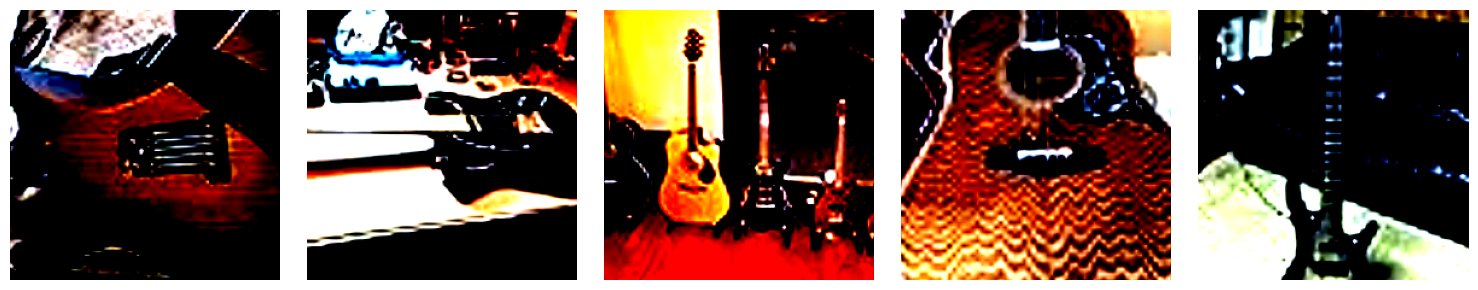

In [29]:
# Visualize preprocessed images
num_images_to_visualize = 5
fig, axes = plt.subplots(1, num_images_to_visualize, figsize=(15, 3))

for i, url in enumerate(image_urls[:num_images_to_visualize]):
    # Load image from URL
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert('RGB')
    
    # Apply preprocessing
    preprocessed_image = preprocess(image)
    
    # Display the image
    axes[i].imshow(preprocessed_image.permute(1, 2, 0))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Extract Features from Images
We define a function to extract features from an image using the pre-trained CNN model and the defined preprocessing transformations.

In [30]:
# Function to extract features from an image
def extract_features(image_url):
    try:
        # Load image from URL
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an exception for bad status codes
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
        # Apply preprocessing
        image = preprocess(image).unsqueeze(0)
        # Forward pass through the model
        with torch.no_grad():
            features = model(image)
        # Flatten features
        features = features.squeeze().numpy()
        return features
    except Exception as e:
        print(f"Error processing image from {image_url}: {e}")
        return None

In [31]:
# Extract features for each image and store in a dictionary
features_dict = {}
for idx, url in enumerate(image_urls):
    print(f"Extracting features for image {idx+1}/{len(image_urls)}")
    features = extract_features(url)
    if features is not None:
        features_dict[url] = features

Extracting features for image 1/1000
Extracting features for image 2/1000
Extracting features for image 3/1000
Extracting features for image 4/1000
Extracting features for image 5/1000
Extracting features for image 6/1000
Extracting features for image 7/1000
Extracting features for image 8/1000
Extracting features for image 9/1000
Extracting features for image 10/1000
Extracting features for image 11/1000
Extracting features for image 12/1000
Extracting features for image 13/1000
Extracting features for image 14/1000
Extracting features for image 15/1000
Extracting features for image 16/1000
Extracting features for image 17/1000
Extracting features for image 18/1000
Extracting features for image 19/1000
Extracting features for image 20/1000
Extracting features for image 21/1000
Extracting features for image 22/1000
Extracting features for image 23/1000
Extracting features for image 24/1000
Extracting features for image 25/1000
Extracting features for image 26/1000
Extracting features f

In [32]:
print('features_dict', features_dict)

features_dict {'https://images-na.ssl-images-amazon.com/images/I/81q5+IxFVUL._SY88.jpg': array([0.48856282, 0.27544865, 0.31666353, ..., 0.82583827, 1.2205664 ,
       0.60147434], dtype=float32), 'https://images-na.ssl-images-amazon.com/images/I/71HSx4Y-5dL._SY88.jpg': array([0.6404203 , 0.5474036 , 0.69472903, ..., 0.26129663, 1.0618975 ,
       0.21455555], dtype=float32), 'https://images-na.ssl-images-amazon.com/images/I/71Md5ihUFLL._SY88.jpg': array([0.7171606 , 0.03457023, 0.5761951 , ..., 0.04257608, 1.0887399 ,
       0.481072  ], dtype=float32), 'https://images-na.ssl-images-amazon.com/images/I/71Isri9SEaL._SY88.jpg': array([0.76875806, 0.54082036, 0.32273403, ..., 0.24558334, 1.1898098 ,
       0.3563667 ], dtype=float32), 'https://images-na.ssl-images-amazon.com/images/I/71w8aOdrTuL._SY88.jpg': array([1.1847906 , 0.5523516 , 0.7050524 , ..., 0.26107955, 0.6799397 ,
       0.55081385], dtype=float32), 'https://images-na.ssl-images-amazon.com/images/I/81dxkALs4CL._SY88.jpg': a

## Save Results
- Save the extracted image features using the pickle module.

In [33]:
# Destination path for saving dumps
destination_path = r'C:\Users\HP\Documents\Shrugal IIITD\Semester 8\Information Retrieval\CSE508_Winter2024_A2_2020408\dumps\image_feature_extraction_dumps'

# Ensure the directory exists, create if not
os.makedirs(destination_path, exist_ok=True)

# File path for saving extracted features
extracted_features_path = os.path.join(destination_path, 'extracted_features.pkl')

# Save extracted features using pickle
with open(extracted_features_path, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Extracted features saved to: {extracted_features_path}")

Extracted features saved to: C:\Users\HP\Documents\Shrugal IIITD\Semester 8\Information Retrieval\CSE508_Winter2024_A2_2020408\dumps\image_feature_extraction_dumps\extracted_features.pkl
